### **CLIP4Clip 사전학습 모델 불러오기**

In [ ]:
# Load pretrained CLIP4Clip model from Hugging Face Hub 
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("Searchium-ai/clip4clip-webvid150k")
model = AutoModelForZeroShotImageClassification.from_pretrained("Searchium-ai/clip4clip-webvid150k") # (8.5s)

/opt/anaconda3/envs/clip4clip/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### **텍스트(event decription) 임베딩 추출하기**

In [ ]:
# Extracting Text Embeddings
import numpy as np
import torch
from transformers import CLIPTokenizer, CLIPTextModelWithProjection


search_sentence = "a person is falling down"

model = CLIPTextModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
tokenizer = CLIPTokenizer.from_pretrained("Searchium-ai/clip4clip-webvid150k")

inputs = tokenizer(text=search_sentence , return_tensors="pt")
outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

# Normalize embeddings for retrieval:
final_output = outputs[0] / outputs[0].norm(dim=-1, keepdim=True)
final_output = final_output.cpu().detach().numpy()
text_embeddings = final_output
print(text_embeddings.shape) # 1.2s

# print("final output: \n", final_output)


(1, 512)


In [7]:
type(text_embeddings)

numpy.ndarray

### **비디오(event video) 임베딩 추출하기**

In [ ]:
# Extracting Video Embeddings
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
from PIL import Image
import cv2
import numpy as np
import torch

# convert one video to few images.  
def video2image(video_path, frame_rate=2, size=224): # 초당 frame_rate 개수로 균등 추출    
    def preprocess(size, n_px):  # 이미지를 전처리하여 텐서로 변환 -> 반환된 텐서는 (추출된 프레임 개수, 채널 수, h, w)의 형태(크기)
        return Compose([
            Resize(size, interpolation=InterpolationMode.BICUBIC),            
            CenterCrop(size),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # RGB 채널별 평균과 표준편차로 정규화 수행.
        ])(n_px)  # n_px: PIL 이미지 객체
    
    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if fps < 1:  # FPS가 유효하지 않은 경우, 빈 배열을 반환하고 오류 메시지
        images = np.zeros([3, size, size], dtype=np.float32) 
        print("ERROR: problem reading video file: ", video_path)
    else:
        total_duration = (frameCount + fps - 1) // fps
        start_sec, end_sec = 0, total_duration
        interval = fps / frame_rate
        frames_idx = np.floor(np.arange(start_sec*fps, end_sec*fps, interval))

        ret = True     # 본격적으로 프레임을 읽어와 전처리
        images = np.zeros([len(frames_idx), 3, size, size], dtype=np.float32)
        
        for i, idx in enumerate(frames_idx):
            cap.set(cv2.CAP_PROP_POS_FRAMES , idx)
            ret, frame = cap.read()    
            if not ret: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)             
            last_frame = i
            images[i,:,:,:] = preprocess(size, Image.fromarray(frame).convert("RGB")) # 읽어온 프레임을 PIL 이미지로 변환한 뒤, 전처리를 거쳐 텐서로 변환. -> images 배열에 저장
            
        images = images[:last_frame+1]
    cap.release()
    video_frames = torch.tensor(images)
    return video_frames

    
vid_example = '/Users/jisu/Desktop/25.상/졸업프로젝트/AIhub-편의점이상-Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4'
video = video2image(vid_example) # 7.2s

In [4]:
video.shape

torch.Size([120, 3, 224, 224])

In [6]:
from transformers import CLIPVisionModelWithProjection

model = CLIPVisionModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
model = model.eval()
# # Extracting video embeddings per frame
# video = video.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
# video = video.to(model.device) # move to GPU
# video_embeddings = []
# for i in range(video.shape[0]):
#     video[i] = video[i].to(model.device) # move to GPU
#     # video[i] = video[i].unsqueeze(0) # add batch dimension
#     with torch.no_grad():
#         video_embeddings.append(model(video[i])["image_embeds"])
# video_embeddings = torch.stack(video_embeddings) # (N, 1, 768)
# video_embeddings = video_embeddings.squeeze(1) # (N, 768)
# # Normalizing the embeddings and calculating mean between all embeddings.
# video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
# video_embeddings = torch.mean(video_embeddings, dim=0)
# video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
# print(video_embeddings.shape)

visual_output = model(video)

# Normalizing the embeddings and calculating mean between all embeddings. 
visual_output = visual_output["image_embeds"]
visual_output = visual_output / visual_output.norm(dim=-1, keepdim=True)
visual_output = torch.mean(visual_output, dim=0)
visual_output = visual_output / visual_output.norm(dim=-1, keepdim=True)
print(visual_output)

tensor([-2.7121e-02, -3.2603e-02,  2.0232e-02,  6.0055e-02,  1.6490e-02,
         6.4757e-04,  1.4627e-02,  1.1159e-02, -4.6573e-02,  5.5162e-03,
         1.9931e-02, -6.7308e-03,  7.5266e-03,  1.0034e-02,  1.1848e-02,
        -1.3109e-02, -5.1471e-02,  1.1918e-02,  1.7858e-03, -8.9834e-03,
        -7.5532e-02, -8.5189e-03,  1.2312e-02,  1.4048e-02, -6.6083e-02,
         3.6595e-02,  7.7150e-02,  1.2730e-02, -2.1984e-02, -2.8322e-02,
        -1.4181e-03,  4.4522e-02, -1.2353e-02, -5.6600e-02,  5.6986e-02,
        -1.0617e-02, -3.4750e-02, -8.0639e-03,  3.3338e-03, -4.6503e-02,
        -6.7008e-02,  1.7114e-02,  4.6976e-02, -2.8077e-02, -1.3263e-02,
         8.9786e-03, -6.4736e-02, -1.9511e-03,  2.1264e-02, -3.2526e-02,
         2.7339e-02, -5.2238e-02, -2.1553e-03,  1.1082e-02,  7.1944e-03,
         4.3347e-02, -2.1386e-02, -1.1697e-02,  4.9807e-02,  3.0858e-02,
         2.0597e-02, -2.7559e-02, -1.5067e-02,  2.9414e-02, -6.8743e-03,
         4.6964e-03,  3.1279e-02,  2.6731e-01, -2.5

In [8]:
type(visual_output), len(visual_output), visual_output.shape

(torch.Tensor, 512, torch.Size([512]))

### **텍스트-이미지(비디오프레임) 유사도 계산**

In [10]:
text_embeddings.shape

(1, 512)

In [ ]:
visual_embeddings = visual_output.unsqueeze(0) # 토치텐서에 특정 차원을 추가하는 데 사용되는 함수

visual_output.shape, visual_embeddings.shape # torch.Size([512]) -> torch.Size([1, 512]); text_embeddings 와 차원 맞춰주기

(torch.Size([512]), torch.Size([1, 512]))

In [16]:
type(text_embeddings), type(visual_embeddings)

(numpy.ndarray, torch.Tensor)

In [17]:
text_tensor = torch.Tensor(text_embeddings)
type(text_tensor)

torch.Tensor

In [18]:
# sim_matrix = np.matmul(text_embeddings, visual_embeddings.T)
sim_matrix = torch.matmul(text_tensor, visual_output.T)
print("Similarity matrix shape: ", sim_matrix.shape)

Similarity matrix shape:  torch.Size([1])


/var/folders/y9/nm4qdmtn143d63hcl5r54xbr0000gn/T/ipykernel_87684/613075051.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_f2vdv9nc2o/croot/pytorch-select_1725908300995/work/aten/src/ATen/native/TensorShape.cpp:3679.)
  sim_matrix = torch.matmul(text_tensor, visual_output.T)


In [ ]:
sim_matrix # 전체 영상(뭉뚱그려진)과 텍스트 간의 유사도 값

tensor([0.1502], grad_fn=<MvBackward0>)

### **프레임(sparse) 단위 처리**

In [28]:
torch.backends.mps.is_available()

False

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)

vid_example = '/Users/jisu/Desktop/25.상/졸업프로젝트/Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4'
video = video2image(vid_example)
video.shape

Device:  cpu
ERROR: problem reading video file:  /Users/jisu/Desktop/25.상/졸업프로젝트/Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4


[ WARN:0@371.786] global cap.cpp:206 open VIDEOIO(FFMPEG): backend is generally available but can't be used to capture by name


torch.Size([3, 224, 224])

In [29]:
video.shape

torch.Size([120, 3, 224, 224])

In [30]:
from transformers import CLIPVisionModelWithProjection

model = CLIPVisionModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
model = model.eval()

video_file = '/Users/jisu/Desktop/25.상/졸업프로젝트/AIhub-편의점이상-Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4'
video = video2image(video_file)
print(video.shape) # torch.Size([120, 3, 224, 224]) > 1분 남짓

# Extracting video embeddings per frame
# video = video.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
    # CLIP 모델 pixel_values 입력, (N, 3, 224, 224) 형식
video = video.to(model.device) # move to GPU

video_embeddings = []
for i in range(video.shape[0]):
    video[i] = video[i].to(model.device) # move to GPU
    # video[i] = video[i].unsqueeze(0) # add batch dimension
    with torch.no_grad():
        # video_embeddings.append(model(video[i])["image_embeds"])
        video_embeddings.append(model(pixel_values=video)["image_embeds"])

video_embeddings = torch.stack(video_embeddings) # (N, 1, 768)
video_embeddings = video_embeddings.squeeze(1) # (N, 768)


# Normalizing the embeddings and calculating mean between all embeddings.
video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
video_embeddings = torch.mean(video_embeddings, dim=0)
video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)


print(video_embeddings.shape) # torch.Size([120, 512])-> cpu연산으로 12분 10초 소요

torch.Size([120, 3, 224, 224])
torch.Size([120, 512])


sparse하게 추출한 120개의 프레임(c x h x w) 을 통해 각 프레임에 대한 임베딩을 추출함: `video` -> `video_embeddings`

In [61]:
# Extracting Text Embeddings
import numpy as np
import torch
from transformers import CLIPTokenizer, CLIPTextModelWithProjection


search_sentence = "a person is lying down"

model = CLIPTextModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
tokenizer = CLIPTokenizer.from_pretrained("Searchium-ai/clip4clip-webvid150k")

inputs = tokenizer(text=search_sentence , return_tensors="pt")
outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

# Normalize embeddings for retrieval:
final_output = outputs[0] / outputs[0].norm(dim=-1, keepdim=True)
print(final_output.shape) # torch.Size([1, 512])

text_embeddings = final_output.cpu().detach().numpy()
text_embeddings.shape # 1.4s

torch.Size([1, 512])


(1, 512)

In [62]:
import matplotlib.pyplot as plt

# 코사인 유사도 계산: 각 프레임과 텍스트 사이
# 결과: [120]
similarities = torch.matmul(video_embeddings, final_output.T).squeeze(1)  # (120, 1) -> (120,)
similarities.shape

torch.Size([120])

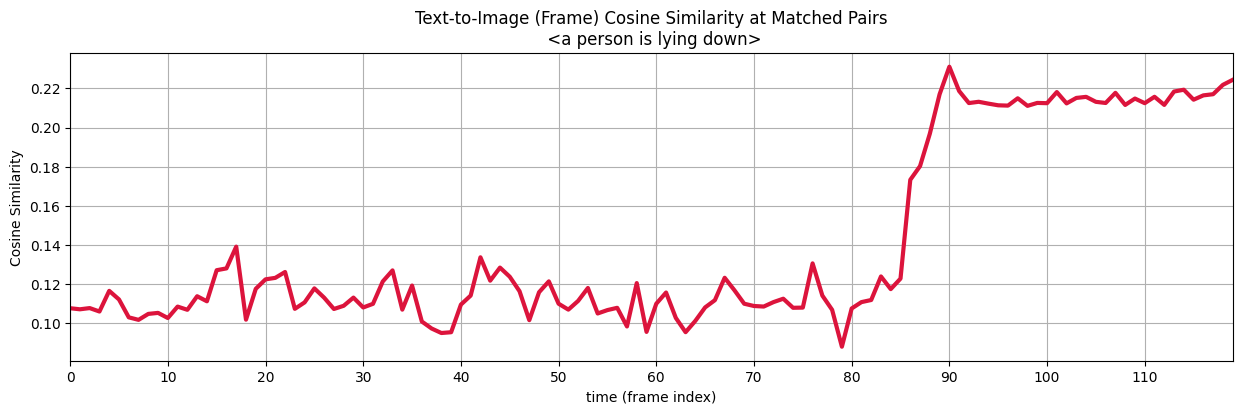

In [74]:
plt.figure(figsize=(15, 4))
plt.plot(similarities.detach().numpy(), c='crimson', linewidth=3) # , marker='o'
plt.title("Text-to-Image (Frame) Cosine Similarity at Matched Pairs\n " + f"<{search_sentence}>")
plt.xlim(0, similarities.shape[0]-1)
plt.xticks(np.arange(0, similarities.shape[0], 10)) # x축 눈금 간격 설정
plt.xlabel("time (frame index)")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

torch.Size([1, 512])
(1, 512)
torch.Size([120])


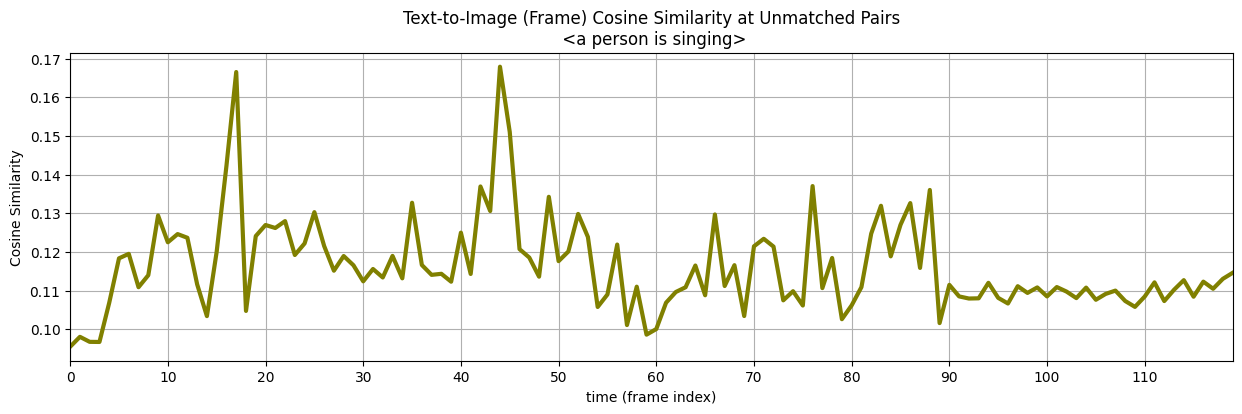

In [75]:
# Extracting Text Embeddings
import numpy as np
import torch
from transformers import CLIPTokenizer, CLIPTextModelWithProjection


unmatched_sentence = "a person is singing"
inputs = tokenizer(text=unmatched_sentence , return_tensors="pt")
unmatched_outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

# Normalize embeddings for retrieval:
unmatched_final_output = unmatched_outputs[0] / unmatched_outputs[0].norm(dim=-1, keepdim=True)
print(unmatched_final_output.shape) # torch.Size([1, 512])

text_embeddings = unmatched_final_output.cpu().detach().numpy()
print(text_embeddings.shape) # (1,512)

dis_similarities = torch.matmul(video_embeddings, unmatched_final_output.T).squeeze(1)  # (120, 1) -> (120,)
print(dis_similarities.shape) # torch.Size([120])

plt.figure(figsize=(15, 4))
plt.plot(dis_similarities.detach().numpy(), c='olive', linewidth=3) 
plt.title("Text-to-Image (Frame) Cosine Similarity at Unmatched Pairs\n " + f"<{unmatched_sentence}>")
plt.xlim(0, dis_similarities.shape[0]-1)
plt.xticks(np.arange(0, dis_similarities.shape[0], 10)) # x축 눈금 간격 설정
plt.xlabel("time (frame index)")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

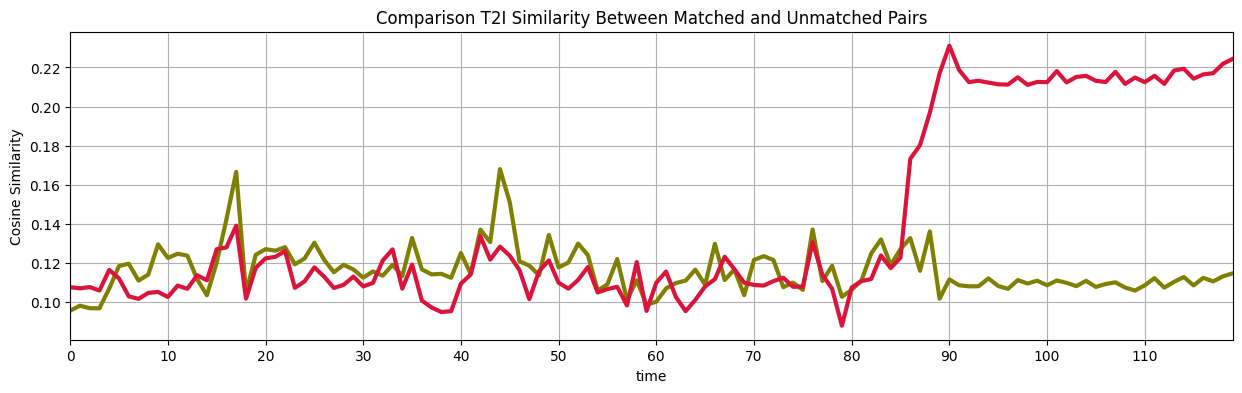

In [77]:
plt.figure(figsize=(15, 4))
plt.plot(dis_similarities.detach().numpy(), c='olive', linewidth=3)
plt.plot(similarities.detach().numpy(), c='crimson', linewidth=3)
plt.title("Comparison T2I Similarity Between Matched and Unmatched Pairs")
plt.xlim(0, similarities.shape[0]-1)
plt.xticks(np.arange(0, similarities.shape[0], 10))
plt.xlabel("time")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

- 현재 프레임에 대해 추론하지 않고 비디오에 대해 **하나의 (뭉개진) 대표 임베딩만을 사용하면, 비교적 낮은 점수 -> 이상상황 판단에 유용하지X**

In [44]:
mean_pooled_visual_output = torch.mean(video_embeddings, dim=0)             # mean of all embeddings: torch.Size([512])
mean_pooled_visual_output = mean_pooled_visual_output / mean_pooled_visual_output.norm(dim=-1, keepdim=True) # normalizing the embeddings: torch.Size([512])

# Calculate similarity between text and video
similarity = torch.dot(final_output.squeeze(), mean_pooled_visual_output)
similarity

tensor(0.1540, grad_fn=<DotBackward0>)

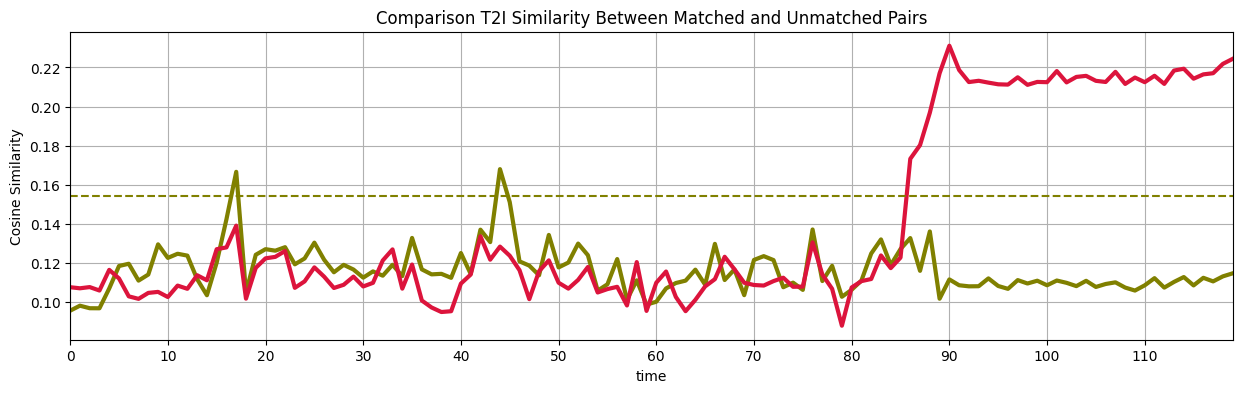

In [88]:
plt.figure(figsize=(15, 4))
plt.plot(dis_similarities.detach().numpy(), c='olive', linewidth=3)
plt.plot(similarities.detach().numpy(), c='crimson', linewidth=3)
plt.title("Comparison T2I Similarity Between Matched and Unmatched Pairs")
plt.xlim(0, similarities.shape[0]-1)
plt.xticks(np.arange(0, similarities.shape[0], 10))
plt.xlabel("time")
plt.ylabel("Cosine Similarity")
plt.grid(True)

similarity_value = similarity.item()  # Convert tensor to a scalar value
plt.axhline(y=similarity_value, color='olive', linestyle='--', label=f'Similarity: {similarity_value:.4f}')  # Add horizontal line

plt.show()

In [89]:
# TODO: 영상 전처리
# TODO: 유사도 output 정규화 
# TODO: 프레임별 추론 플롯 y축 고정
# TODO: 일련의 처리과정을 모듈화